# Biological Network Embedding

## Introduction
Network embedding aims to learn lower dimensional representations of nodes in the network, that enables to use off-the-shelf machine learning algorithms for downstream tasks such as Node classification, Link Prediction, Clustering and Visualization.

In biology, various components of a living cell within an organism interacts with each other to carry the basic functionalities. For example, protein interacts with other proteins to carry biological processes. Proteins and their interactions can be modeled as a network, where protein are nodes and interactions are edges connecting corresponding proteins.

In this post, We will first embed the each proteins in the yeast protein-protein interaction networks extracted from [BioGRID](https://thebiogrid.org) database. You can access the preprocessed data from [GitHub](https://github.com/kckishan/BioNetEmbedding/blob/master/data/yeast/edgelist_biogrid.txt). The idea of embedding proteins is to make the interacting proteins closer in the embedding space. Our task on hand is to predict the missing interactions between proteins.

## Exploring the network properties

In [1]:
# Loading libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Libraries for embedding mode
from argument_parser import argument_parser
from utils import table_printer
from models import Trainer

In [2]:
edgelist_file = "data/yeast/edgelist_biogrid.txt"
edgelist = pd.read_csv(edgelist_file, sep=' ', header=None)
graph = nx.from_edgelist(edgelist.values[:, :2].tolist())

In [3]:
print("Number of nodes in the network is {}.".format(graph.order()))
print("Number of interactions in the network is {}.".format(graph.size() * 2))

Number of nodes in the network is 5638.
Number of interactions in the network is 977472.


## Degree distribution of the network

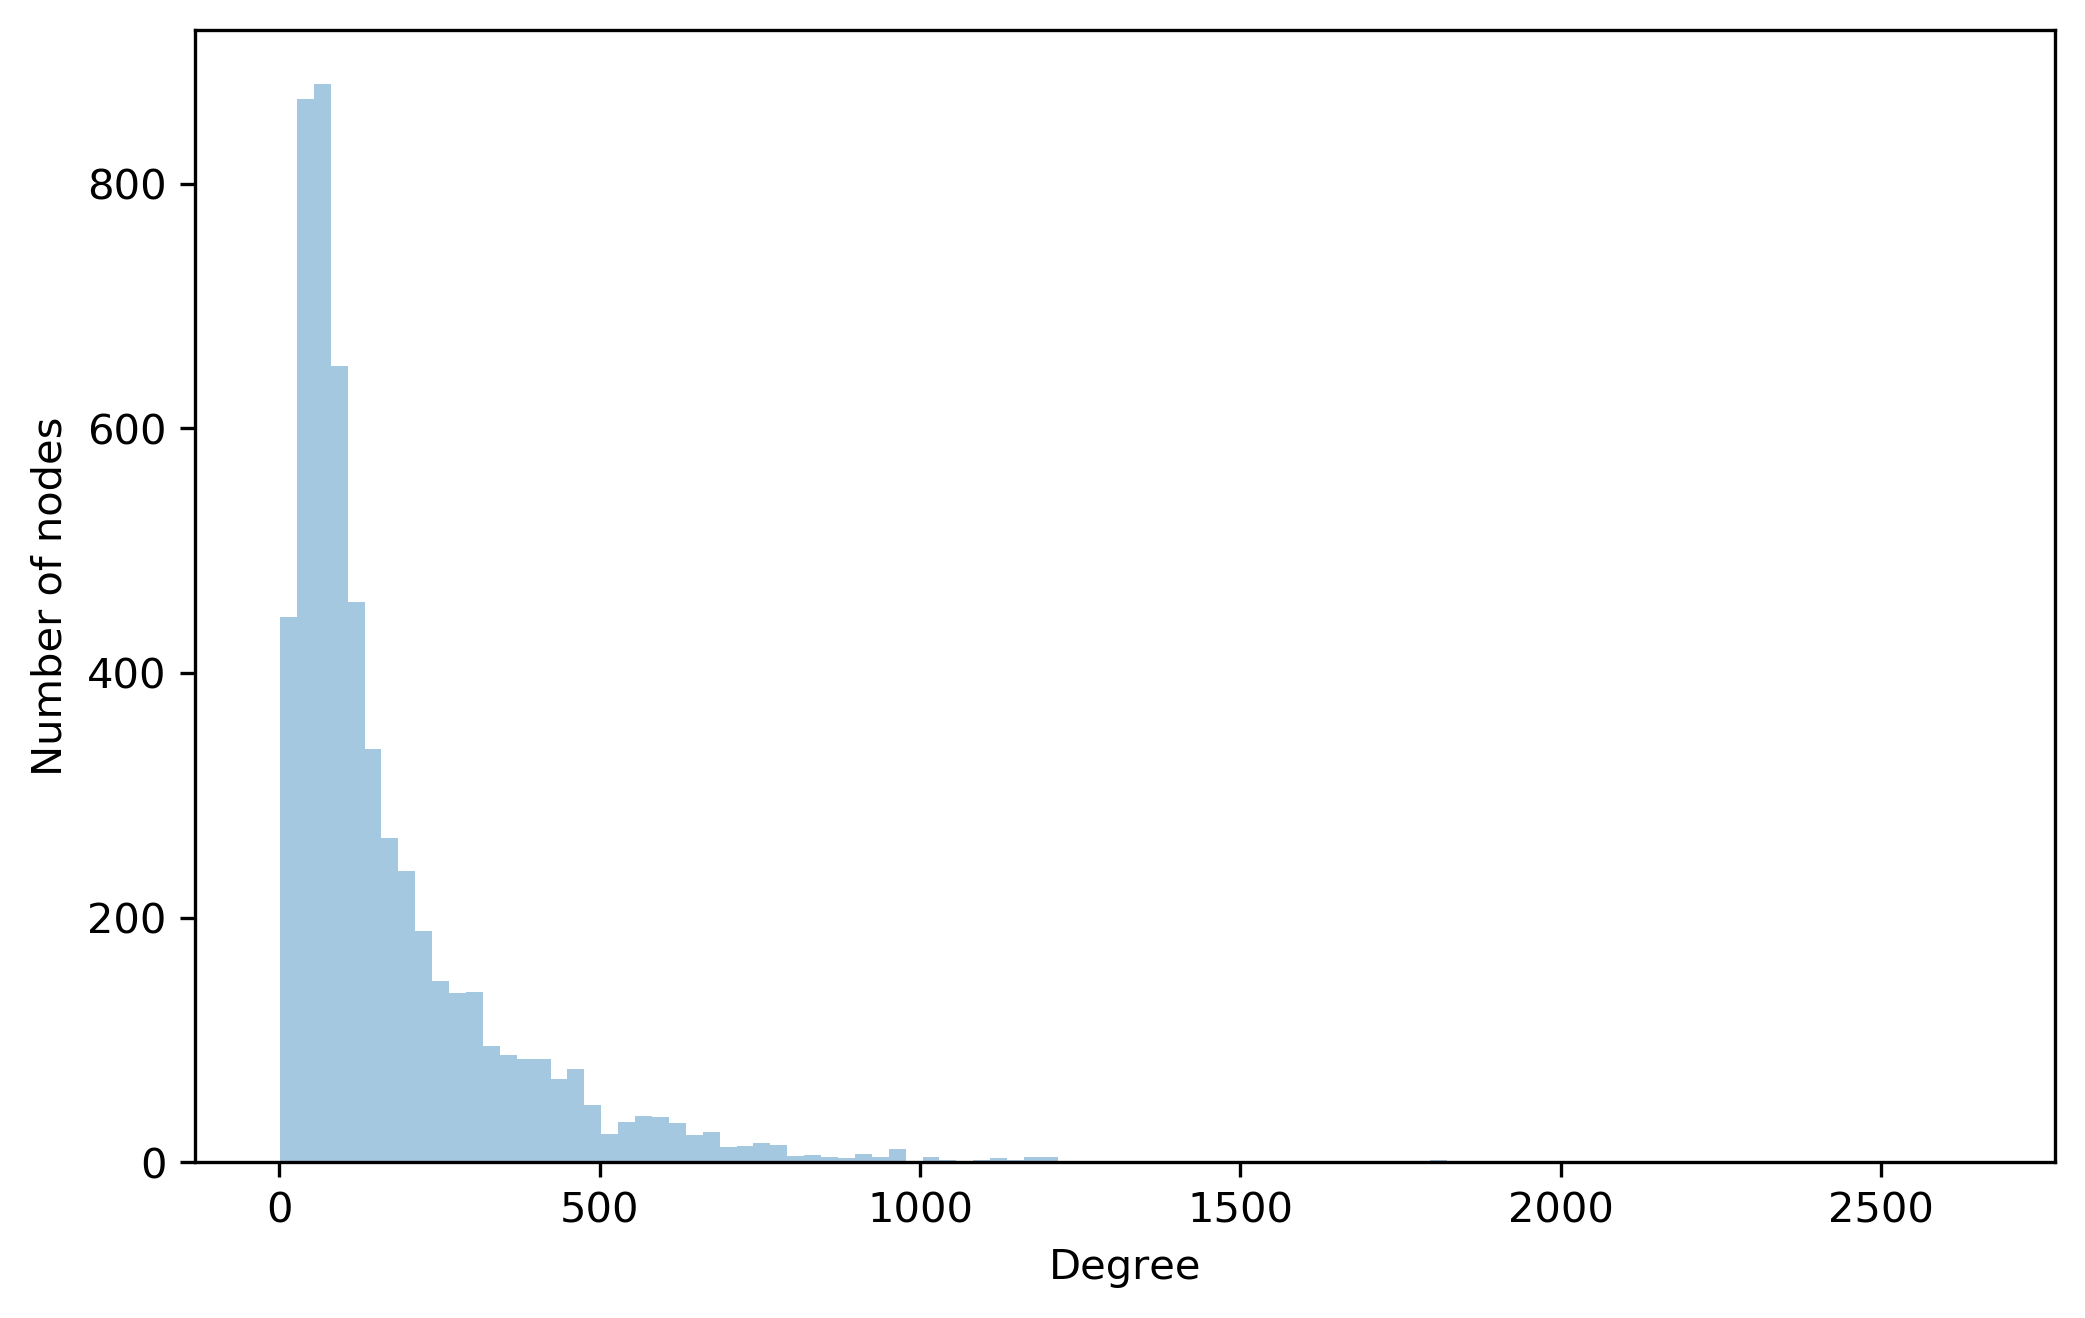

In [4]:
plt.figure(figsize=(8, 5), dpi=300)
degrees = np.asarray([degree for node, degree in graph.degree()])
sns.distplot(degrees, bins= 100, kde=False)
plt.xlabel('Degree')
plt.ylabel('Number of nodes') 
plt.show()

In [5]:
print("Maximum degree: ", degrees.max())
print("Minimum degree: ", degrees.min())

Maximum degree:  2640
Minimum degree:  1


# Embedding yeast network

Let's look at the value of different parameters that controls the performance of our embedding model.

In [6]:
args = argument_parser()

In [7]:
table_printer(args)

+----------------+----------------------+
|   Parameter    |        Value         |
+================+======================+
| Batch size     | 256                  |
+----------------+----------------------+
| Data folder    | ./data/              |
+----------------+----------------------+
| Dataset        | yeast                |
+----------------+----------------------+
| Dropout        | 0.200                |
+----------------+----------------------+
| Early stopping | 10                   |
+----------------+----------------------+
| Edgelist file  | edgelist_biogrid.txt |
+----------------+----------------------+
| Emb dim        | 128                  |
+----------------+----------------------+
| Epochs         | 20                   |
+----------------+----------------------+
| L2 penalty     | 0.000                |
+----------------+----------------------+
| Latent size    | 128                  |
+----------------+----------------------+
| Lr             | 0.001          

Edgelist file are placed inside "data/yeast/". Above table shows the name of the file inside that folder.

I have created a **Trainer** module that helps to load data, define neural network model, train and evaluate it. You can see the code for Trainer in [BioNetEmbedding](https://github.com/kckishan/BioNetEmbedding/blob/master/models/Trainer.py).

In [8]:
trainer = Trainer(args)

Trainer class contains *setup_features* function to load interactions and randomly splits it into training, validation and test set (85%:10%:5%).

In [9]:
trainer.setup_features()

### Loading [./data/yeast/edgelist_biogrid.txt]...
Total genes: 5638
Training interactions (positive):    830848
Training interactions (negative):    415424
Validation interactions (positive):  97746
Validation interactions (negative):  97746
Test interactions (positive):        48876
Test interactions (negative):        48876


Function *setup_model* defines embedding model to learn lower dimensional representations for each protein.

In [10]:
trainer.setup_model()

BioNetEmbedding(
  (net_embedding): Embedding(5638, 128)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Embedding(5638, 128)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (sampled_softmax): SampledSoftmax(
    (params): Linear(in_features=128, out_features=5638, bias=True)
  )
  (criterion): CrossEntropyLoss()
)


Given a training pair (A, B), BioNetEmbedding maximizes the probability of interactions between the pair. 

Details of model working:
1. *Embedding(5368, 128)* encodes the one-hot encoded representation of 5368 proteins identifier to a embedded vector of dimension 128.
2. Linear layer then projects the embedded vector to different space $z \in \mathbb{R}^{5638 \times 128}$.

Let's consider these steps as  $$z = f_{\theta}(x)$$ where $\theta$ represents the trainable weights and biases of the neural network. We further pass these latent representation $z$ through softmax layer that maximizes the proximity score between interacting proteins and minimizes the score for non-interacting proteins. 
Softmax layer can be presented as:
$$p(A|B) = \frac{\exp{(\hat{z}_A \cdot z_B)}}{\sum_{i = 1}^{5368}\exp{(\hat{z}_i \cdot z_B)}}$$ 

where $\hat{z}$ is the weights on the softmax layer. 

Computing the denominator of above equation is computationally expensive. So, we adopt the approach of <cite>[negative sampling][1]</cite> which samples the negative interactions, interactions with no evidence of their existence, according to some noise distribution for each interaction. This approach allows us to sample a small subset of genes from the network as negative samples for a gene, considering that the genes on selected subset don’t fall in the neighborhood $N_B$ of the gene. Now, above equation becomes:
$$\frac{\exp{(\hat{z}_A \cdot z_B)}}{\sum_{i \in N_B}\exp{(\hat{z}_i \cdot z_B)}}$$

Above objective function enhances the similarity of a gene viwith its neighborhood genes $i \in N_B$ and weakens the similarity with genes not in its neighborhood genes $i \notin N_B$. It is inappropriate to assume that the two genes in the network are not related if they are not connected. It may be the case that there is not enough experimental evidence to support that they are related yet. Thus, forcing the dissimilarity of a gene with all other genes, not in its neighborhood $N_B$ seems to be inappropriate.


After training the model, we predict the probability of interactions between protein A and B by taking the dot product between the embeddings of protein A and B and squeezing it through sigmoid function.
$$probability = \sigma(z_A \cdot z_B)$$

[1]: https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

## Training the model

### Processing data for training
We need to convert the numpy arrays of our data to tensors so that we can train our model.

In [11]:
trainer.setup_training_data()

Now, we can train our model with the training data and monitor its performance on validation data.

In [12]:
trainer.fit()

Epoch:   1, Training Loss: 1.684, Validation AUC: 0.8498 Validation PR: 0.8638 *
Epoch:   2, Training Loss: 1.569, Validation AUC: 0.8880 Validation PR: 0.9034 *
Epoch:   3, Training Loss: 1.510, Validation AUC: 0.9052 Validation PR: 0.9193 *
Epoch:   4, Training Loss: 1.465, Validation AUC: 0.9128 Validation PR: 0.9261 *
Epoch:   5, Training Loss: 1.434, Validation AUC: 0.9171 Validation PR: 0.9298 *
Epoch:   6, Training Loss: 1.424, Validation AUC: 0.9196 Validation PR: 0.9318 *
Epoch:   7, Training Loss: 1.398, Validation AUC: 0.9220 Validation PR: 0.9340 *
Epoch:   8, Training Loss: 1.387, Validation AUC: 0.9242 Validation PR: 0.9365 *
Epoch:   9, Training Loss: 1.374, Validation AUC: 0.9240 Validation PR: 0.9365 
Epoch:  10, Training Loss: 1.370, Validation AUC: 0.9218 Validation PR: 0.9354 
Early stopping
Total Training time:  167.99464678764343


### Visualization of training loss and validation performance

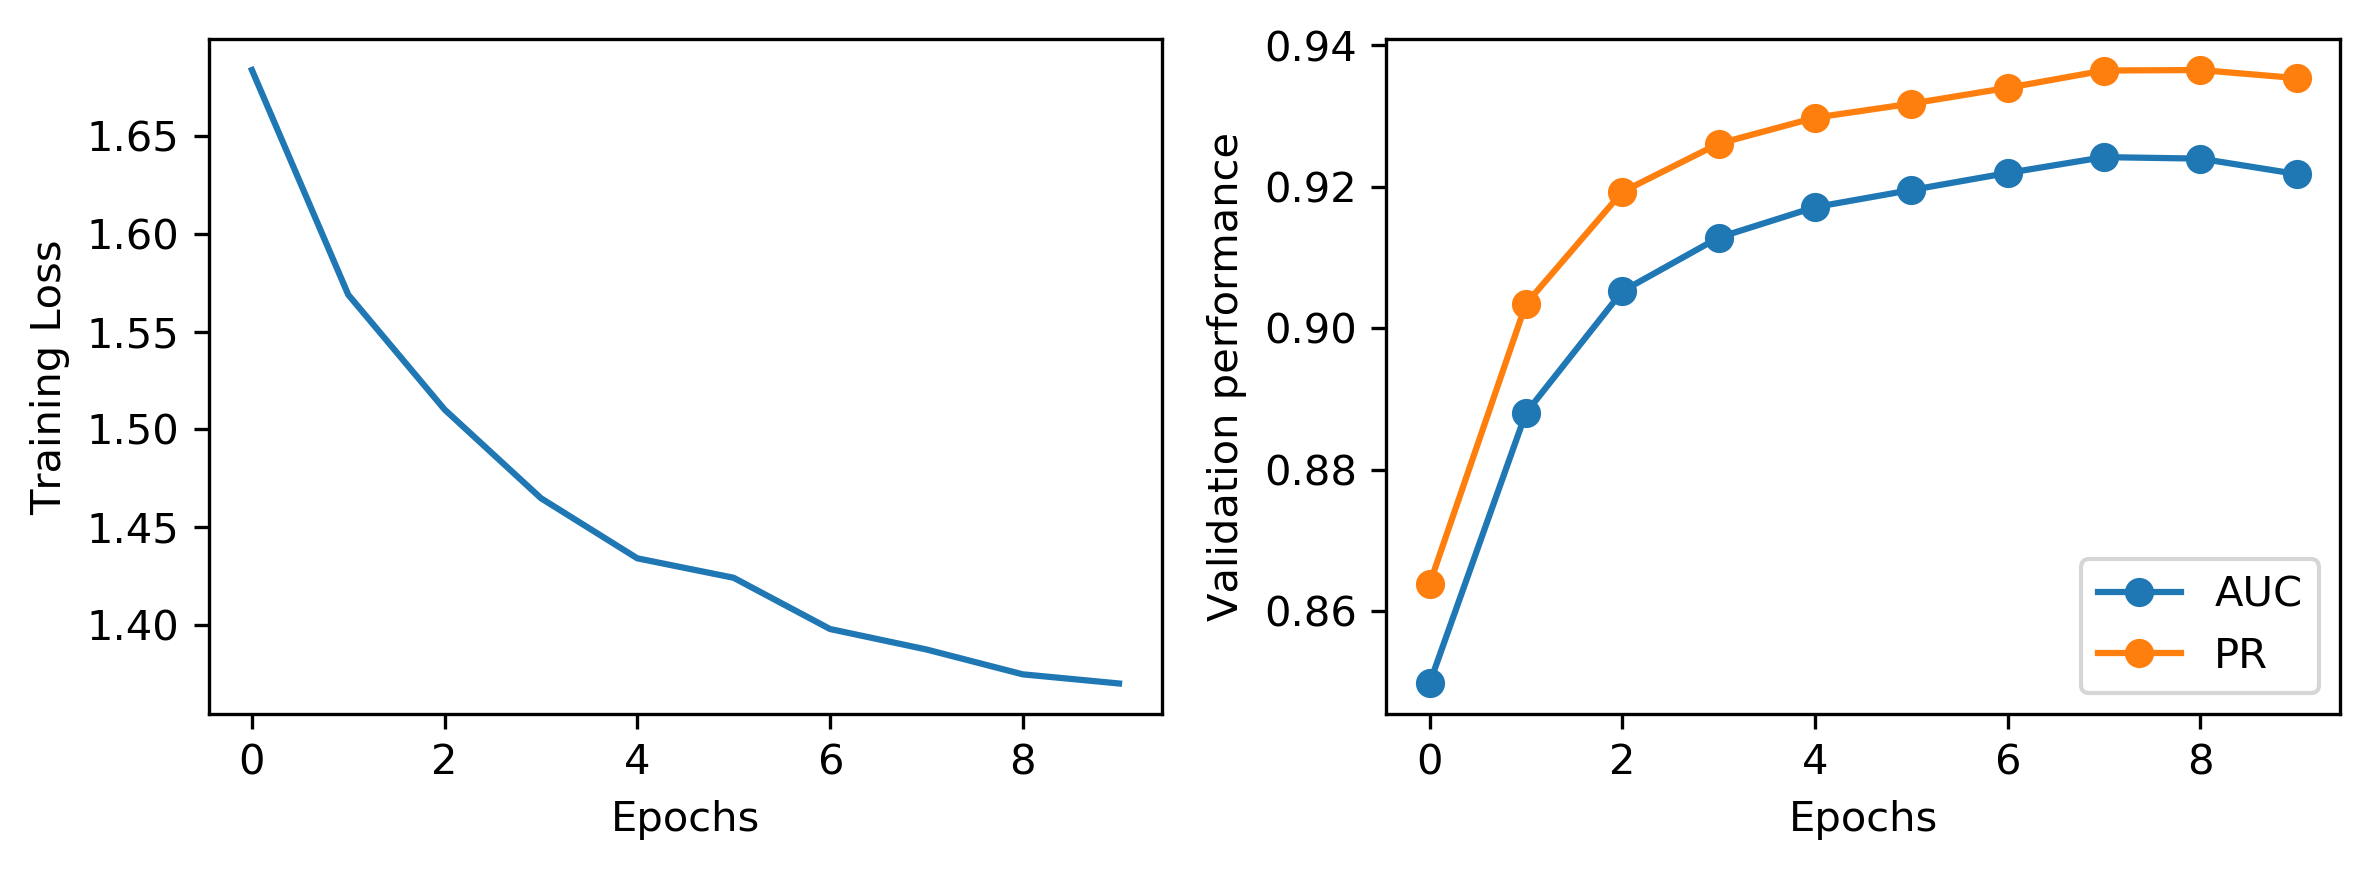

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(8, 3))
ax1.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax1.set_ylabel("Training Loss")
ax1.set_xlabel("Epochs")

ax2.plot(range(len(trainer.valid_auc)), trainer.valid_auc, marker="o", label="AUC")
ax2.plot(range(len(trainer.valid_pr)), trainer.valid_pr, marker="o", label="PR")

ax2.set_ylabel("Validation performance")
ax2.set_xlabel("Epochs")
plt.tight_layout()
plt.legend()
plt.show()

### Evaluation of the model on test data

In [17]:
trainer.evaluate()

Test ROC Score: 0.942, Test AP score: 0.951
